# Welcome to BabySmurf!

This is a quick startup notebook to show off what this software can do.

In [1]:
# startup
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline
import babysmurf as bs

## Demodulation only

We first examine the demodulation algorithm independent of the frequency error estimation. This is described in Section 3.2. The general idea is that we rely on the quasisinusoidal nature of the flux ramp modulated resonance frequency to create a template against which we can fit the phase modulation induced by the signal. 

First, let's create a signal in the time domain. For a small-aperture telescope with no additional polarization modulation, the science band is approximately 0.1 to 1 Hz. Let's create a sine wave with 0.5Hz period.

Text(0, 0.5, 'amplitude [arb]')

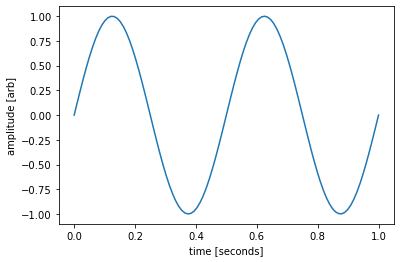

In [2]:
fsig = 0.5 # 0.5 Hz signal

tvec = np.linspace(0,1,100) # create 1 second of data
sig = np.sin(2 * np.pi * (1/fsig) * tvec)

plt.plot(tvec,sig)
plt.xlabel('time [seconds]')
plt.ylabel('amplitude [arb]')

We need to scale this by a reasonable amount for CMB signal. This obviously depends a bit on the setup of the experiment, which can vary pretty wildly between all the different experiments under consideration. For a T_CMB equivalent of ~1mK, we have ..

For now, let's just use a small fraction of a Phi0: 

In [3]:
scalefac = 0.1
scaledsig = scalefac * sig

Now we modulate a SQUID curve by this signal. We can generate a SQUID curve by inputting one, eg. as measured by SMuRF. Here, we use the babysmurf function to generate one with a known peak to peak frequency swing. 

Text(0, 0.5, 'frequency difference [kHz]')

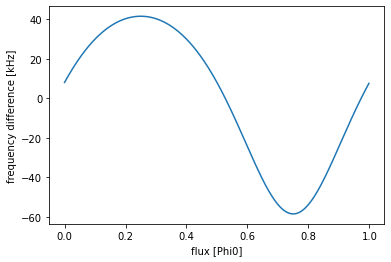

In [4]:
squid = bs.make_squid_curve(0.33,100.e3) # lambda = 0.33, 100kHz peak to peak frequency swing

# plot it
plt.plot(np.arange(len(squid)) / len(squid),squid * 1e-3)
plt.xlabel('flux [Phi0]')
plt.ylabel('frequency difference [kHz]')

We can compare this SQUID curve to one with a higher lambda (SQUID hysteresis parameter) value. NIST aims for ~0.33 in their fab, but we have seen some with lambdas more like 0.7 before.

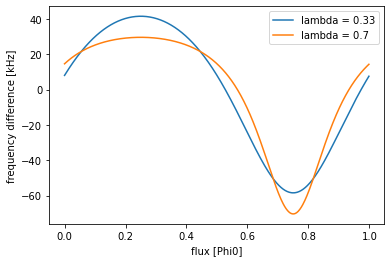

In [5]:
squid2 = bs.make_squid_curve(0.7,100.e3) # lambda = 0.33, 100kHz peak to peak frequency swing

# plot the comparison
plt.plot(np.arange(len(squid)) / len(squid),squid * 1e-3, label='lambda = 0.33')
plt.plot(np.arange(len(squid2)) / len(squid2),squid2 * 1e-3, label='lambda = 0.7')
plt.xlabel('flux [Phi0]')
plt.ylabel('frequency difference [kHz]')
plt.legend()

Now we modulate the SQUID curve according to the signal. The phase modulation scheme is quite crude; we perturb entire flux ramp frames. Later I may add a standard phase modulation scheme that has no knowledge of the "flux ramp frame" notion, but this construction is ideal for playing with effects such as the non-linearity of the generated flux ramp signal. 

Text(0.5, 1.0, 'modulated SQUID frequency')

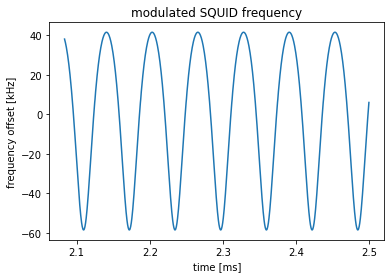

In [6]:
m,t,ph = bs.make_measured_signal(tvec,scaledsig,squid,reset_rate=4.e3) # take nphi0=4, fsamp = 2.4MHz as defaults, but 4kHz reset rate as is common

# plot a subset of the output
plt.plot(t[5000:6000] * 1e3,m[5000:6000] * 1e-3)
plt.xlabel('time [ms]')
plt.ylabel('frequency offset [kHz]')
plt.title('modulated SQUID frequency')

Armed with this, we can try demodulating. This allows us to examine only the impact of the demodulation algorithm independent of tracking on the reconstruted signal. 

In [7]:
d,p,y,e,a = bs.lms_fit_demod_meas(m,reset_rate=4.e3)

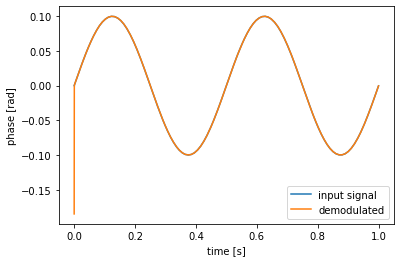

In [8]:
# examine outputs

# d = demodulated phase, sampled at FR reset rate
# p = estimated phases, sampled at full digitizer rate
# y = estimated frequency, sampled at full digitizer rate
# e = errors, sampled at full digitizer rate
# a = alphas, sampled at full digitizer rate

tt = np.linspace(0,1,len(d))
plt.plot(tt,ph - np.mean(ph),label='input signal')
plt.plot(tt,d - np.mean(d),label='demodulated')
plt.xlabel('time [s]')
plt.ylabel('phase [rad]')
plt.legend()

We can also plot things like the estimated frequency and frequency error...

Text(0.5, 0.98, 'Estimated Frequency and Frequency Error')

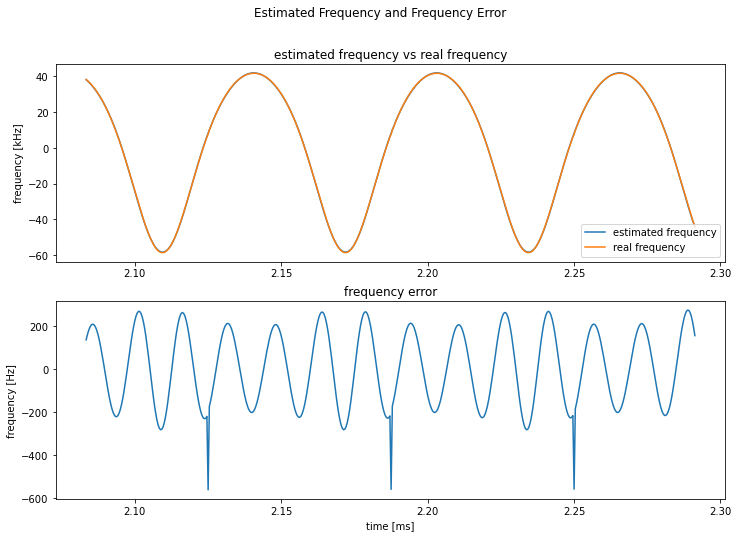

In [9]:
fig,ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(t[5000:5500]*1e3,y[5000:5500]*1e-3,label='estimated frequency')
ax[0].plot(t[5000:5500]*1e3,m[5000:5500]*1e-3,label='real frequency')
#ax[0].set_xlabel('time [ms]')
ax[0].set_ylabel('frequency [kHz]')
ax[0].set_title('estimated frequency vs real frequency')
ax[0].legend()

ax[1].plot(t[5000:5500]*1e3,e[5000:5500])
ax[1].set_xlabel('time [ms]')
ax[1].set_title('frequency error')
ax[1].set_ylabel('frequency [Hz]')



plt.suptitle('Estimated Frequency and Frequency Error')


Armed with this, we can already test something like how gain impacts the reconstructed signal. 

In [10]:
#gains = [1/1024, 1/256, 1/32, 1/8, 1/2]
gains = [1/8]
darray = np.zeros((np.shape(d)[0],len(gains)))
for idx,g in enumerate(gains):
    print(idx)
    dd,_,_,_,_ = bs.lms_fit_demod_meas(m,reset_rate=4.e3,gain=g)
    darray[:,idx] = np.ravel(dd)

0


Text(0.5, 1.0, 'Reconstructed phase vs. gain')

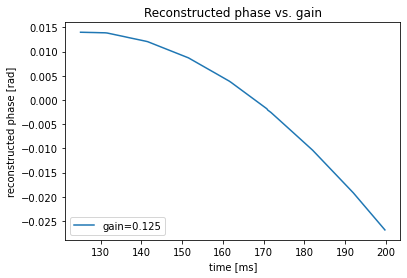

In [11]:
for idx,g in enumerate(gains):
    plt.plot(tt[500:800]*1e3,darray[500:800,idx]-np.mean(darray[500:800,idx]),label=f"gain={g}")
plt.xlabel('time [ms]')
plt.ylabel('reconstructed phase [rad]')
plt.legend(loc="lower left")
plt.title('Reconstructed phase vs. gain')

Text(0.5, 1.0, 'Reconstructed phase vs. gain')

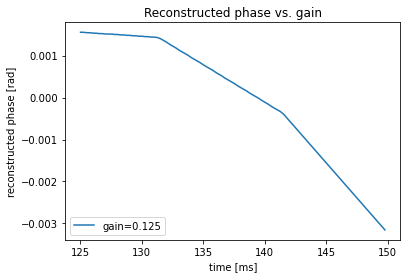

In [12]:
for idx,g in enumerate(gains):
    plt.plot(tt[500:600]*1e3,darray[500:600,idx]-np.mean(darray[500:600,idx]),label=f"gain={g}")
plt.xlabel('time [ms]')
plt.ylabel('reconstructed phase [rad]')
plt.legend(loc="lower left")
plt.title('Reconstructed phase vs. gain')

Text(0.5, 1.0, 'Reconstructed phase error vs. gain')

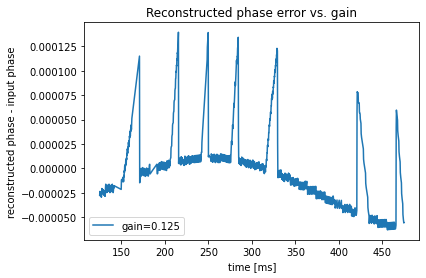

In [13]:
for idx,g in enumerate(gains):
    plt.plot(tt[500:1900]*1e3,(darray[500:1900,idx]-np.mean(darray[500:1900,idx]))-(ph[500:1900] - np.mean(ph[500:1900])),label=f"gain={g}")
#plt.ylim([0.95,1.05])
plt.xlabel('time [ms]')
plt.ylabel('reconstructed phase - input phase')
plt.legend(loc="lower left")
plt.title('Reconstructed phase error vs. gain')

This is super interesting! Since these are already mean subtracted, it implies that there is some real amplitude-diminishing effect with very small gain. It would be interesting to explore the limits of this in either direction. It does seem like there is a broad range of gains which are approximately equivalent...

# Generating resonators and estimating frequency error

The other main component of the SMuRF baseband processor is the frequency error estimation. This is described extensively in Sec. 3.2 of the proceedings. Here we walk through generating a resonance, calculating its calibration factor, and estimating frequency error.

The resonator is parameterized by a resonance frequency, total Q, and coupled Q. We can generate its S21 and plot magnitude, phase, and resonance circle:

Text(0.5, 0.98, 'Ideal resonance with f$_{res}$=5.5GHz')

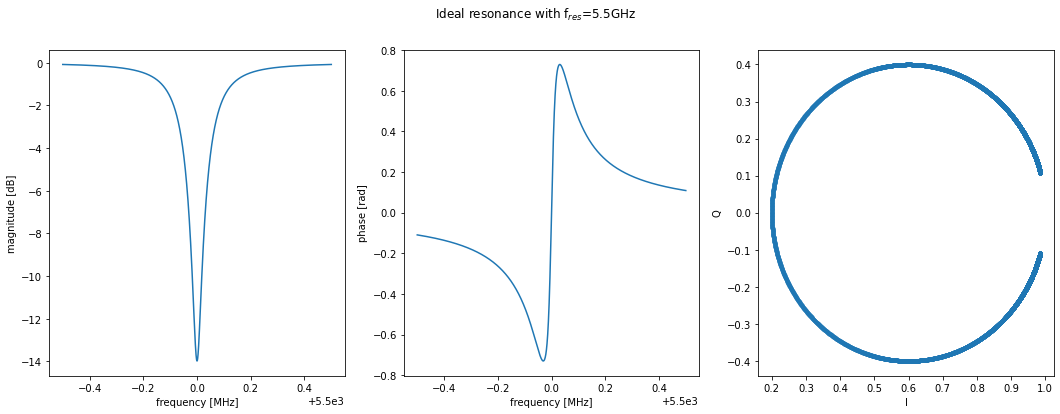

In [14]:
# define resonator parameters similar to typical umux100k chips from NIST
fres = 5.5e9 # 5.5GHz
Qtot = 4.e4 # aim for bandwidth of 100kHz
Qc = 5.e4 # all real for now, not asymmetric

fvec = np.linspace(fres-500.e3,fres+500.e3,int(1e4)) # 1kHz spacing on fvec

a,p = bs.make_res_s21(fres,fvec,Qtot,Qc)

fig,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(fvec*1e-6,20*np.log10(a))
ax[0].set_xlabel('frequency [MHz]')
ax[0].set_ylabel('magnitude [dB]')

ax[1].plot(fvec*1e-6,p)
ax[1].set_xlabel('frequency [MHz]')
ax[1].set_ylabel('phase [rad]')

# get sin,cos components
ivec = a*np.cos(p)
qvec = a*np.sin(p)
ax[2].plot(ivec,qvec,'.')
ax[2].set_xlabel('I')
ax[2].set_ylabel('Q')
plt.suptitle(r'Ideal resonance with f$_{res}$=5.5GHz')

Note that near the resonance frequency, the circle is approximately parallel to the Q axis. We can arbitrarily rotate the circle by adding a phase delay and rescale the size by adding some attenuation:

Text(0.5, 0.98, 'Resonance with added phase delay and amplitude change')

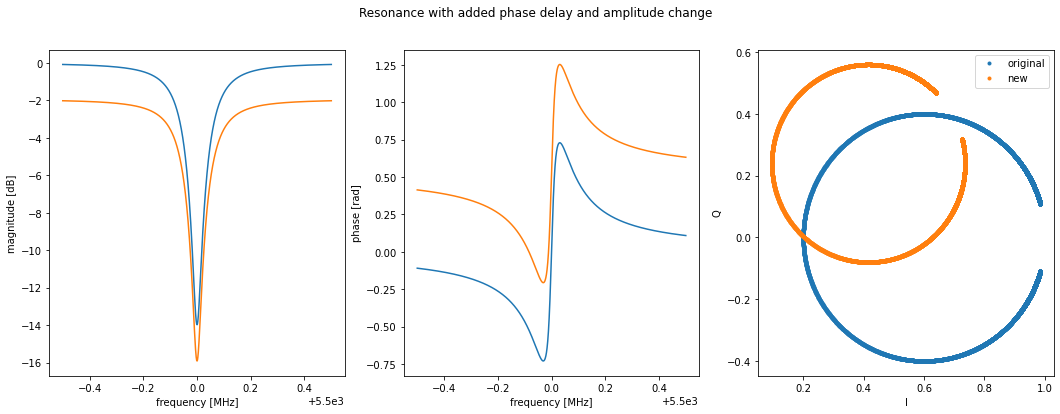

In [15]:
delay = 30 # degrees
scalefac = 0.8
p2 = np.deg2rad(delay) + p
a2 = scalefac * a # multiplication by scale factor in amplitude equivalent to shifting up/down in logmag space

fig,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(fvec*1e-6,20*np.log10(a),label='original')
ax[0].plot(fvec*1e-6,20*np.log10(a2),label='new')
ax[0].set_xlabel('frequency [MHz]')
ax[0].set_ylabel('magnitude [dB]')

ax[1].plot(fvec*1e-6,p,label='original')
ax[1].plot(fvec*1e-6,p2,label='new')
ax[1].set_xlabel('frequency [MHz]')
ax[1].set_ylabel('phase [rad]')

# get sin,cos components
ivec = a*np.cos(p)
qvec = a*np.sin(p)
ivec2 = a2*np.cos(p2)
qvec2 = a2*np.sin(p2)
ax[2].plot(ivec,qvec,'.',label='original')
ax[2].plot(ivec2,qvec2,'.',label='new')
ax[2].set_xlabel('I')
ax[2].set_ylabel('Q')
ax[2].legend()

plt.suptitle(r'Resonance with added phase delay and amplitude change')

We seek to re-rotate and scale the "new" circle back to the original, ideal circle. This is accomplished by measuring the response near the resonance frequency and rescaling/aligning it to be parallel to the Q axis. This is plotted below:

Text(0.5, 0.98, 'eta estimation points')

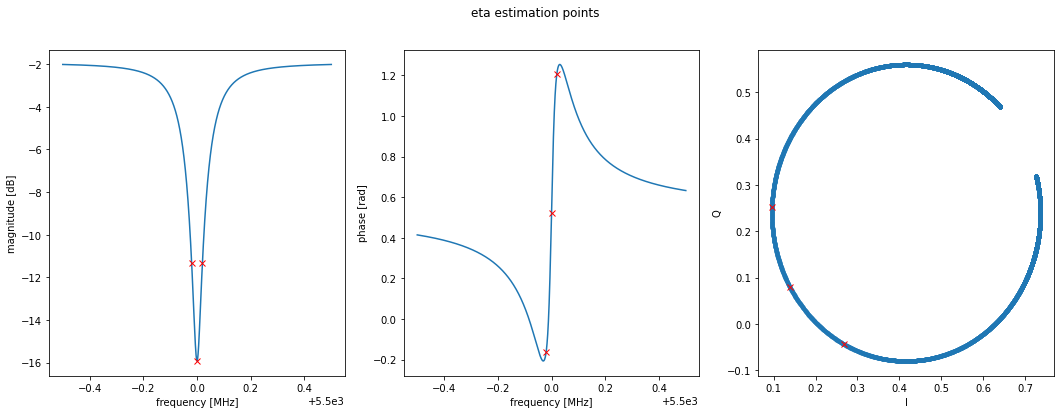

In [16]:
offset = 20.e3 # we typically do ~20 kHz

# estimate the resonance frequency from the S21, since we usually don't know that a priori
# read the docstring to see different resonance frequency finding options, but SMuRF currently implements a max phase slip finder by default

fres_est,fres_idx = bs.estimate_res_freq(fvec,a2,p2)
fp_idx = np.where(np.abs(fvec-(fres_est+offset)) == np.min(np.abs(fvec-(fres_est+offset))))[0][0]
fn_idx = np.where(np.abs(fvec-(fres_est-offset)) == np.min(np.abs(fvec-(fres_est-offset))))[0][0]
index_array = np.asarray([fn_idx,fres_idx,fp_idx])

fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].plot(fvec*1e-6,20*np.log10(a2))
ax[0].plot(fvec[index_array]*1e-6,20*np.log10(a2[index_array]),'rx')
ax[0].set_xlabel('frequency [MHz]')
ax[0].set_ylabel('magnitude [dB]')

ax[1].plot(fvec*1e-6,p2)
ax[1].plot(fvec[index_array]*1e-6,p2[index_array],'rx')
ax[1].set_xlabel('frequency [MHz]')
ax[1].set_ylabel('phase [rad]')

ivec2 = a2*np.cos(p2)
qvec2 = a2*np.sin(p2)
ax[2].plot(ivec2,qvec2,'.')
ax[2].plot(ivec2[index_array],qvec2[index_array],'rx')
ax[2].set_xlabel('I')
ax[2].set_ylabel('Q')

plt.suptitle('eta estimation points')

Estimating and eta and rescaling the resonance circle, we find that it does pretty well at capturing the original resonance circle in this instance. Note that the axes have changed a lot: this is essentially transforming the resonator I/Q parameters in digitizer units into something with meaningful units. 

(-58386.763600829254-100816.34104557575j)


Text(0.5, 0.98, 'resonance circle vs ideal before/after calibration')

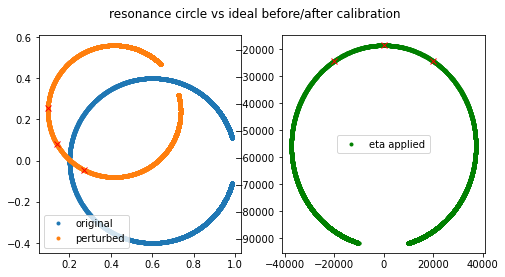

In [17]:
fres = 5.5e9 # 5.5GHz
Qtot = 4.e4 # aim for bandwidth of 100kHz
Qc = 5.e4 # all real for now, not asymmetric

fvec = np.linspace(fres-500.e3,fres+500.e3,int(1e4)) # 1kHz spacing on fvec

a,p = bs.make_res_s21(fres,fvec,Qtot,Qc)
delay = 30 # degrees
scalefac = 0.8
p2 = np.deg2rad(delay) + p
a2 = scalefac * a # multiplication by scale factor in amplitude equivalent to shifting up/down in logmag space

eta = bs.estimate_eta(fvec,a2,p2,offset=offset)
print(eta)

ivec = a*np.cos(p)
qvec = a*np.sin(p)
ivec2 = a2*np.cos(p2)
qvec2 = a2*np.sin(p2)

s21 = ivec2 + 1j*qvec2
eta = bs.estimate_eta(fvec,a2,p2,offset=offset)
s21_new = s21 * eta
ivec_eta = np.real(s21_new)
qvec_eta = np.imag(s21_new)

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(ivec,qvec,'.',label='original')
ax[0].plot(ivec2,qvec2,'.',label='perturbed')
ax[0].plot(ivec2[index_array],qvec2[index_array],'rx')
ax[0].legend()
ax[1].plot(ivec_eta,qvec_eta,'g.',label='eta applied')
ax[1].plot(ivec_eta[index_array],qvec_eta[index_array],'rx')
#ax[1].set_xlim([0,1.e5])
#ax[1].set_ylim([-2.e4,8.e4])
ax[1].legend()
plt.suptitle('resonance circle vs ideal before/after calibration')

Need to check all the conventions on I/Q!

But in any case, it doesn't quite matter what the convention is as long as we consistently take the correct axis in the error estimation. Now we can put in a probe tone at, say, 5.5GHz - 20kHz, and estimate the frequency error using eta:

In [18]:
probe_f = fres - 20.e3

fest = bs.estimate_freq_error(fvec,a2,p2,eta,probe_f)
print(f"actual frequency error = {(probe_f - fres) * 1e-3} kHz")
print(f"estimated frequency error = {fest * 1e-3} kHz")

actual frequency error = -20.0 kHz
estimated frequency error = -20.03107871454641 kHz


Not bad! We can map out the estimate vs offset for ~the resonance bandwidth:

Text(0.5, 0.98, 'estimated vs actual error')

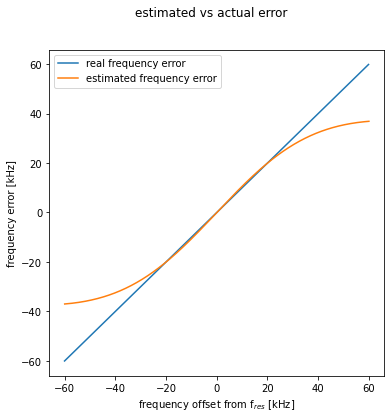

In [19]:
npts = 500
sweep_f = np.linspace(fres-60.e3,fres+60.e3,npts)
ests = np.zeros((npts,))

for ii in np.arange(npts):
    ests[ii] = bs.estimate_freq_error(fvec,a2,p2,eta,sweep_f[ii])
    
fp_idx = np.where(np.abs(fvec-(fres_est+60.e3)) == np.min(np.abs(fvec-(fres_est+60.e3))))[0][0]
fn_idx = np.where(np.abs(fvec-(fres_est-60.e3)) == np.min(np.abs(fvec-(fres_est-60.e3))))[0][0]
    
fig,ax = plt.subplots(1,1,figsize=(6,6))
ax.plot((fvec[fn_idx:fp_idx] - fres)*1e-3,(fvec[fn_idx:fp_idx]-fres)*1e-3,label='real frequency error')
ax.plot((sweep_f-fres)*1e-3, ests*1e-3,label='estimated frequency error')
ax.set_xlabel('frequency offset from f$_{res}$ [kHz]')
ax.set_ylabel('frequency error [kHz]')
ax.legend()

plt.suptitle('estimated vs actual error')

We see here that the estimation is slightly offset, likely due to an off-by-one indexing bug in finding the resonance frequency. We can perturb the OFFSET USE DIFFERENT WORD) frequency at which eta is estimated and see how it improves the estimate:

In [20]:
offsets = [1.,5.,10.,20.,30.] # kHz
npts = 500
sweep_f = np.linspace(fres-60.e3,fres+60.e3,npts)
ests = np.zeros((npts,len(offsets)))

for ii in np.arange(len(offsets)):
    eta = bs.estimate_eta(fvec,a2,p2,offsets[ii] * 1.e3)
    for jj in np.arange(npts):
        ests[jj,ii] = bs.estimate_freq_error(fvec,a2,p2,eta,sweep_f[jj])

Text(0.5, 0.98, 'estimated offset vs actual offset, varying eta estimation factors')

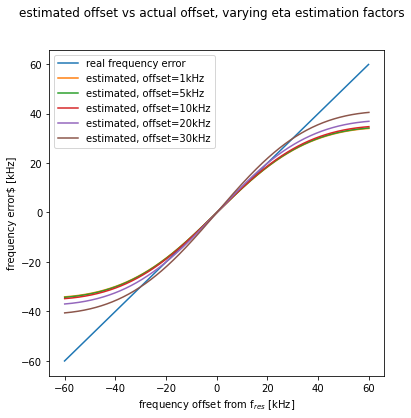

In [21]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
    
fp_idx = np.where(np.abs(fvec-(fres_est+60.e3)) == np.min(np.abs(fvec-(fres_est+60.e3))))[0][0]
fn_idx = np.where(np.abs(fvec-(fres_est-60.e3)) == np.min(np.abs(fvec-(fres_est-60.e3))))[0][0]
ax.plot((fvec[fn_idx:fp_idx]-fres)*1e-3,(fvec[fn_idx:fp_idx]-fres)*1e-3,label='real frequency error')
    
for ii in np.arange(len(offsets)):
    ax.plot((sweep_f-fres)*1e-3, ests[:,ii]*1e-3,label=f'estimated, offset={int(offsets[ii])}kHz')
    
ax.set_xlabel('frequency offset from f$_{res}$ [kHz]')
ax.set_ylabel('frequency error$ [kHz]')
ax.legend()

plt.suptitle('estimated offset vs actual offset, varying eta estimation factors')

Furthermore, we can construct an asymmetric resonance and repeat the exercise. Here we generate a highly asymmetric resonance and reproduce the above plots for it:

Text(0.5, 0.98, 'asymmetric resonance and eta estimation points')

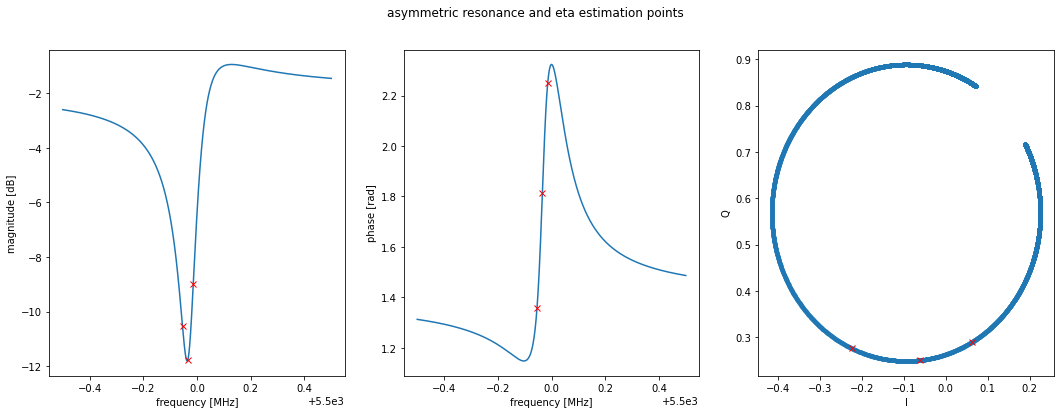

In [22]:
fres = 5.5e9 # 5.5GHz
Qtot = 4.e4
Qc = 4.e4 + 3.e4j # now this is complex

fvec = np.linspace(fres-500.e3,fres+500.e3,int(1e4)) # 1kHz spacing on fvec

a,p = bs.make_res_s21(fres,fvec,Qtot,Qc)

# perturb it
delay = 80 # degrees
scalefac = 0.8
p2 = np.deg2rad(delay) + p
a2 = scalefac * a # multiplication by scale factor in amplitude equivalent to shifting up/down in logmag space

offset = 20.e3 # we typically do ~20 kHz

fres_est,fres_idx = bs.estimate_res_freq(fvec,a2,p2)
fp_idx = np.where(np.abs(fvec-(fres_est+offset)) == np.min(np.abs(fvec-(fres_est+offset))))[0][0]
fn_idx = np.where(np.abs(fvec-(fres_est-offset)) == np.min(np.abs(fvec-(fres_est-offset))))[0][0]
index_array = np.asarray([fn_idx,fres_idx,fp_idx])

fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].plot(fvec*1e-6,20*np.log10(a2))
ax[0].plot(fvec[index_array]*1e-6,20*np.log10(a2[index_array]),'rx')
ax[0].set_xlabel('frequency [MHz]')
ax[0].set_ylabel('magnitude [dB]')

ax[1].plot(fvec*1e-6,p2)
ax[1].plot(fvec[index_array]*1e-6,p2[index_array],'rx')
ax[1].set_xlabel('frequency [MHz]')
ax[1].set_ylabel('phase [rad]')

ivec2 = a2*np.cos(p2)
qvec2 = a2*np.sin(p2)
ax[2].plot(ivec2,qvec2,'.')
ax[2].plot(ivec2[index_array],qvec2[index_array],'rx')
ax[2].set_xlabel('I')
ax[2].set_ylabel('Q')

plt.suptitle('asymmetric resonance and eta estimation points')

/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/n/helmod/apps/centos7/Core/Anaconda3/2021.05-jupyterood-fasrc01/x/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0.98, 'resonance circle vs ideal before/after calibration')

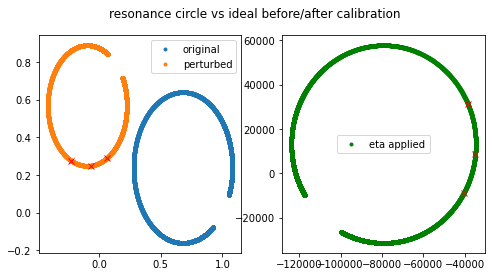

In [23]:
eta = bs.estimate_eta(fvec,a2,p2,offset=offset)

ivec = a*np.cos(p)
qvec = a*np.sin(p)
ivec2 = a2*np.cos(p2)
qvec2 = a2*np.sin(p2)
ivec_eta = ivec2 * eta
qvec_eta = qvec2 * eta

fig,ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(ivec,qvec,'.',label='original')
ax[0].plot(ivec2,qvec2,'.',label='perturbed')
ax[0].plot(ivec2[index_array],qvec2[index_array],'rx')
ax[0].legend()
ax[1].plot(qvec_eta,ivec_eta,'g.',label='eta applied')
ax[1].plot(qvec_eta[index_array],ivec_eta[index_array],'rx')
ax[1].legend()
plt.suptitle('resonance circle vs ideal before/after calibration')

FORCE AXES ON THIS PLOT TO BE SQUARE!!!

Text(0.5, 0.98, 'estimated offset vs actual offset on asymmetric resonance, varying eta estimation factors')

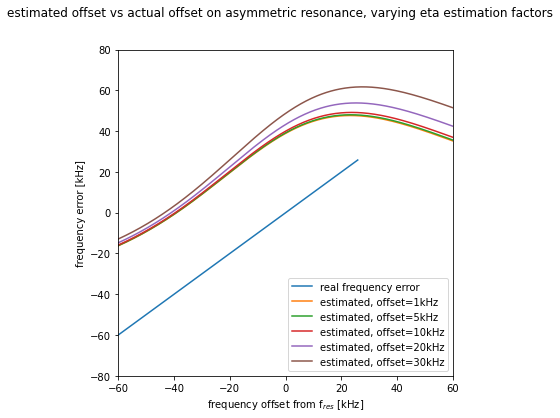

In [24]:
offsets = [1.,5.,10.,20.,30.] # kHz
npts = 500
sweep_f = np.linspace(fres-60.e3,fres+60.e3,npts)
ests = np.zeros((npts,len(offsets)))

for ii in np.arange(len(offsets)):
    eta = bs.estimate_eta(fvec,a2,p2,offsets[ii] * 1.e3)
    for jj in np.arange(npts):
        ests[jj,ii] = bs.estimate_freq_error(fvec,a2,p2,eta,sweep_f[jj])
        
fig,ax = plt.subplots(1,1,figsize=(6,6))
    
fp_idx = np.where(np.abs(fvec-(fres_est+60.e3)) == np.min(np.abs(fvec-(fres_est+60.e3))))[0][0]
fn_idx = np.where(np.abs(fvec-(fres_est-60.e3)) == np.min(np.abs(fvec-(fres_est-60.e3))))[0][0]
ax.plot((fvec[fn_idx:fp_idx]-fres)*1e-3,(fvec[fn_idx:fp_idx]-fres)*1e-3,label='real frequency error')
    
for ii in np.arange(len(offsets)):
    ax.plot((sweep_f-fres)*1e-3, ests[:,ii]*1e-3,label=f'estimated, offset={int(offsets[ii])}kHz')
    
ax.set_xlabel('frequency offset from f$_{res}$ [kHz]')
ax.set_ylabel('frequency error [kHz]')
ax.set_xlim([-60,60])
ax.set_ylim([-80,80])
ax.legend()

plt.suptitle('estimated offset vs actual offset on asymmetric resonance, varying eta estimation factors')

We see here that the resonance asymmetry makes us systematically off in our estimate! Yikes!

In [25]:
probe_f = fres + 20.e3

fest = bs.estimate_freq_error(fvec,a2,p2,eta,probe_f)
print(f"actual frequency error = {(probe_f - fres) * 1e-3} kHz")
print(f"estimated frequency error = {fest * 1e-3} kHz")

actual frequency error = 20.0 kHz
estimated frequency error = 60.839230549210306 kHz


For highly symmetric resonances, we therefore are interested in finding alternate estimates of eta that do better. Since eta is estimated in software, this can be done with just a change to pysmurf and no firmware changes!

# Generate a modulated S21 and track/demod

Putting these things together, we can therefore create a SQUID-modulated S21 and apply the tracking and demodulation algorithms together on it. This way, we can investigate questions such as "how far off can the eta calibration be before the reconstructed signal is wrong?" and "Can you be biased by eta, or simply lose tracking?"

First we construct a SQUID-modulated S21. We do this very naively and simply shift the S21 back and forth in frequency without changing anything else about its shape. This is not quite correct since the rf SQUID is part of the resonator LC circuit and therefore does modulate the resonance beyond its frequency, but these effects are relatively small compared with the resonance frequency shift for umux devices. For KID devices one would have to construct this differently; this would be an interesting avenue to explore!

In [ ]:
# reuse the same measurement from above

# go back to use an ideal resonator here
fres = 5.5e9 # 5.5GHz
Qtot = 5.5e4
Qc = 4.e4 # now this is complex
fvec = np.linspace(fres-100.e3,fres+100.e3,int(1e3)) # 2kHz spacing on fvec

matmag,matphase = bs.make_s21_measurement(fvec,fres + m,Qtot,Qc)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(12,6))
ax[0].imshow(20*np.log10(matmag[:,5000:10000]))
ax[0].set_title('logmag [dB]')
ax[1].imshow(matphase[:,5000:10000])
ax[1].set_title('phase [rad]')

contourf and np.meshgrid

Now we can estimate eta and use that to reconstruct the signal. 

In [ ]:
# estimate eta using the state at time = 0
offset = 20.e3 # 20 kHz offset
eta = bs.estimate_eta(fvec,matmag[:,0],matphase[:,0],offset=offset)

In [ ]:
d,p,y,e,a = bs.lms_fit_demod_track(np.transpose(matmag[:,:600000]),np.transpose(matphase[:,:600000]),fvec,eta,reset_rate=4.e3) # this is annoyingly slow so only do a quarter

In [ ]:
tt = np.linspace(0,len(d)/len(ph),len(d))
plt.plot(tt,ph[:len(d)] - np.mean(ph[:len(d)]),label='input signal')
plt.plot(tt,d - np.mean(d),label='demodulated')
plt.xlabel('time [s]')
plt.ylabel('phase [rad]')
plt.legend()
plt.title('input vs reconstructed signal, tracked and demodulated')

This is pretty cool. We can also answer a question such as "if the resonance drifts but we don't update eta, how badly are we impacted?" This is equivalent to adding a constant delay to the phase before reconstruction.

In [ ]:
offset_angle = 60 # degrees

matphase2 = np.exp(1j*np.deg2rad(offset_angle)) * matphase

d2,p2,y2,e2,a2 = bs.lms_fit_demod_track(np.transpose(matmag[:,:600000]),np.transpose(matphase2[:,:600000]),fvec,eta,reset_rate=4.e3) # only do a quarter because I am impatient

In [ ]:
tt = np.linspace(0,len(d2)/len(ph),len(d2))

plt.plot(tt,d2 - np.mean(d2),label='demodulated')
plt.plot(tt,ph[:len(d2)] - np.mean(ph[:len(d2)]),label='input signal')
plt.xlabel('time [s]')
plt.ylabel('phase [rad]')
plt.legend()
plt.title('delayed phase, non-updated eta')